In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
#import dataframe_image as dfi
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [2]:
def percentile_df(df, cols_to_keep):
    pct_df = pd.DataFrame()
    for col in cols_to_keep:
        pct_df[col] = df[col]
    
    for category in df.columns:
        if (not(category in cols_to_keep)):
            pct_df[category] = df[category].rank(pct = True)*100

    
    return pct_df

In [282]:
path = "/Users/somduttasinha/Google Drive/Personal Projects/afl-simulator/afl-stats/raw-data/average_player_data_2022.csv"
df = pd.read_csv(path)
df

,Unnamed: 0,firstName,surname,id,team,season,jumperNumber,position,dateOfBirth,draftYear,...,extendedStats.ruckContests,extendedStats.contestDefOneOnOnes,extendedStats.contestDefLosses,extendedStats.contestDefLossPercentage,extendedStats.contestOffOneOnOnes,extendedStats.contestOffWins,extendedStats.contestOffWinsPercentage,extendedStats.centreBounceAttendances,extendedStats.kickins,extendedStats.kickinsPlayon
0,0,Aaron,Black,6203,West Coast Eagles,2022,47,MEDIUM_FORWARD,1992-12-25,2021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
1,1,Aaron,Francis,934,Essendon,2022,10,KEY_FORWARD,1997-08-10,2015,...,0.000000,0.000000,0.000000,0.000000,2.250000,0.250000,8.325000,0.000000,0.000000,0.000000
2,2,Aaron,Hall,217,North Melbourne,2022,43,MEDIUM_DEFENDER,1990-11-09,2011,...,0.000000,0.400000,0.100000,10.000000,0.000000,0.000000,0.000000,0.000000,5.400000,4.800000
3,3,Aaron,Naughton,1621,Western Bulldogs,2022,33,KEY_FORWARD,1999-11-30,2017,...,4.315789,0.000000,0.000000,0.000000,3.684211,1.000000,22.831579,0.000000,0.000000,0.000000
4,4,Adam,Cerra,1562,Carlton,2022,5,MIDFIELDER,1999-10-07,2017,...,0.058824,0.000000,0.000000,0.000000,0.058824,0.058824,5.882353,15.176471,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,672,Zach,Tuohy,73,Geelong Cats,2022,2,MEDIUM_DEFENDER,1989-12-10,2012,...,0.000000,0.684211,0.210526,15.789474,0.210526,0.052632,5.263158,0.000000,2.526316,1.842105
673,673,Zaine,Cordy,1084,Western Bulldogs,2022,12,KEY_FORWARD,1996-10-27,2014,...,14.545455,0.727273,0.363636,13.636364,0.636364,0.000000,0.000000,3.545455,0.000000,0.000000
674,674,Zak,Butters,1856,Port Adelaide,2022,18,MIDFIELDER_FORWARD,2000-09-08,2018,...,0.055556,0.111111,0.111111,11.111111,0.277778,0.111111,5.555556,9.277778,0.000000,0.000000
675,675,Zak,Jones,765,St Kilda,2022,3,MIDFIELDER,1995-03-15,2013,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,12.727273,0.000000,0.000000


In [283]:
def create_path(year):
    if year == 2022:
        return "/Users/somduttasinha/Google Drive/Personal Projects/afl-simulator/afl-stats/raw-data/average_player_data_2022.csv"
    else:
        path = "/Users/somduttasinha/Google Drive/Personal Projects/AFL-Stats/"
        return path + str(year)+"_stats.csv"

In [284]:
df = pd.read_csv(create_path(2022))
df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"])
df["age"] = (pd.to_datetime("01/01/2022") - df["dateOfBirth"]) / np.timedelta64(1,'Y')

In [285]:
# inside midfield: 0.4, 0.3. 0.3

def get_midfielders(year, general_weight=0.4, attack_weight=0.3, defence_weight=0.3, max_age=999):
    path = create_path(year)
    cols = ['firstName', 'surname', 'id', 'team', 'season', "gamesPlayed",
       "jumperNumber", 'position', 'dateOfBirth', 'draftYear', 'heightInCm',
       'weightInKg', 'recruitedFrom', 'debutYear', 'draftType',
       'draftPosition', 'data_accessed', "age"]
    df = pd.read_csv(path)
    df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"])
    df["age"] = (pd.to_datetime("24/09/2022") - df["dateOfBirth"]) / np.timedelta64(1,'Y')
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
    df.fillna(0, inplace=True)
    midfielders = df[df["position"].isin(["MIDFIELDER", "MIDFIELDER_FORWARD"])]
    if (year == 2022):
        midfielders = midfielders[midfielders["gamesPlayed"]>11]
    else:
        midfielders = midfielders[midfielders["gamesPlayed"]>12]
    midfielders = percentile_df(midfielders, cols)
    midfielders["General"] = (0.3 * midfielders["contestedPossessions"]) +(0.2 * midfielders["disposals"]) + (0.3 * midfielders["clearances.totalClearances"]) + (0.2 * midfielders["uncontestedPossessions"])
    midfielders["Attack"] = (0.25 * midfielders["shotsAtGoal"]) + (0.25 * midfielders["inside50s"]) + (0.25 * midfielders["metresGained"]) + (0.25 * midfielders["scoreInvolvements"])
    midfielders["Defence"] = (0.4 * midfielders["tackles"]) + (0.4 * midfielders["extendedStats.pressureActs"]) + (0.2 * midfielders["extendedStats.contestOffWins"])
    midfielders["Overall"] = (general_weight * midfielders["General"]) + (attack_weight * midfielders["Attack"]) + (defence_weight * midfielders["Defence"])
    returnable = midfielders[["id", "firstName", "surname", "age", "team","season","gamesPlayed", "General", "Attack", "Defence", "Overall"]]
    #returnable = percentile_df(returnable, cols)
    returnable = returnable.sort_values(by=["Overall"], ascending=False)
    #returnable["Year"] = year
    returnable.reset_index(inplace=True)
    returnable = returnable[returnable["age"] <= max_age]
    returnable.drop(["index"], axis=1, inplace=True)
    returnable.drop(["id"], axis=1, inplace=True)
    returnable.index += 1
    return returnable

In [286]:
midfield_df = get_midfielders(2022,0.4, 0.3, 0.3).head(50)

In [287]:
midfield_df.style.background_gradient(subset='Overall')

,firstName,surname,age,team,season,gamesPlayed,General,Attack,Defence,Overall
1,Clayton,Oliver,25.175055,Melbourne,2022,19,98.529412,79.687500,73.676471,85.420956
2,Rory,Laird,28.737072,Adelaide Crows,2022,18,98.235294,71.047794,80.000000,84.608456
3,Christian,Petracca,26.721972,Melbourne,2022,20,86.544118,99.264706,62.426471,83.125000
4,Lachie,Neale,29.336674,Brisbane Lions,2022,20,92.941176,82.169118,69.117647,82.562500
5,Touk,Miller,26.587815,Gold Coast Suns,2022,20,87.205882,85.018382,73.235294,82.358456
6,Patrick,Cripps,27.521441,Carlton,2022,19,87.205882,82.812500,74.852941,82.181985
7,Marcus,Bontempelli,26.834227,Western Bulldogs,2022,19,72.757353,95.955882,80.294118,81.977941
8,Ben,Keays,25.583003,Adelaide Crows,2022,20,87.794118,78.676471,74.558824,81.088235
9,Darcy,Parish,25.166841,Essendon,2022,14,95.367647,75.183824,59.705882,78.613971
10,Andrew,Brayshaw,22.877951,Fremantle,2022,20,76.507353,78.125000,80.882353,78.305147


In [288]:
def get_rucks(year, general_weight=0.1, attack_weight=0.1, defence_weight=0.1, ruck_weight=0.7, max_age=999):
    path = create_path(year)
    cols = ['firstName', 'surname', 'id', 'team', 'season', "gamesPlayed",
       "jumperNumber", 'position', 'dateOfBirth', 'draftYear', 'heightInCm',
       'weightInKg', 'recruitedFrom', 'debutYear', 'draftType',
       'draftPosition', 'data_accessed', "age"]
    df = pd.read_csv(path)
    df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"])
    df["age"] = (pd.to_datetime("24/09/2022") - df["dateOfBirth"]) / np.timedelta64(1,'Y')

    df.drop(["Unnamed: 0"], axis=1, inplace=True)
    df.fillna(0, inplace=True)
    rucks = df[df["position"].isin(["RUCK"])]
    if (year == 2022):
        rucks = rucks[rucks["gamesPlayed"]>11]
    else:
        rucks = rucks[rucks["gamesPlayed"]>12]
    #rucks = rucks[rucks["contestedPossessions"]>8]
    #rucks["Scoring Shots"] = rucks["Goals"] + rucks["Behinds"]
    rucks = percentile_df(rucks, cols)
    rucks["General"] = (0.3 * rucks["contestedPossessions"]) +(0.2 * rucks["disposals"]) + (0.3 * rucks["clearances.totalClearances"]) + (0.2 * rucks["uncontestedPossessions"])
    rucks["Ruck"] = (0.2 * rucks["hitouts"]) + (0.3 * rucks["extendedStats.hitoutToAdvantageRate"]) + (0.3 * rucks["extendedStats.hitoutWinPercentage"]) + (0.2 * rucks["contestedMarks"])
    rucks["Attack"] = (0.25 * rucks["shotsAtGoal"]) + (0.25 * rucks["inside50s"]) + (0.25 * rucks["metresGained"]) + (0.25 * rucks["scoreInvolvements"])
    rucks["Defence"] = (0.4 * rucks["tackles"]) + (0.4 * rucks["extendedStats.pressureActs"]) + (0.2 * rucks["extendedStats.contestOffWins"])
    rucks["Overall"] = (general_weight * rucks["General"]) + (ruck_weight * rucks["Ruck"])+(attack_weight * rucks["Attack"]) + (defence_weight * rucks["Defence"])
    returnable = rucks[["id", "firstName", "surname", "age", "team","season","gamesPlayed", "General", "Attack", "Defence", "Overall"]]
    #print(rucks[["Name", "Team", "Games Played", "General", "Attack", "Defence", "Overall", "Year"]])
    returnable = returnable.sort_values(by=["Overall"], ascending=False)
    #returnable["Year"] = year
    returnable.reset_index(inplace=True)
    returnable = returnable[returnable["age"] <= max_age]
    returnable.drop(["index"], axis=1, inplace=True)
    returnable.drop(["id"], axis=1, inplace=True)
    returnable.index += 1
    return returnable

In [289]:
get_rucks(2022, max_age=21)

,firstName,surname,age,team,season,gamesPlayed,General,Attack,Defence,Overall
21,Luke,Jackson,20.986057,Melbourne,2022,18,56.25,63.541667,89.166667,38.6875


In [290]:
def get_forwards(year, general_weight=0.1, attack_weight=0.8, pressure_weight=0.1, max_age=999):
    path = create_path(year)
    cols = ['firstName', 'surname', 'id', 'team', 'season', "gamesPlayed",
       "jumperNumber", 'position', 'dateOfBirth', 'draftYear', 'heightInCm',
       'weightInKg', 'recruitedFrom', 'debutYear', 'draftType',
       'draftPosition', 'data_accessed', "age"]
    df = pd.read_csv(path)
    df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"])
    df["age"] = (pd.to_datetime("24/09/2022") - df["dateOfBirth"]) / np.timedelta64(1,'Y')

    df.drop(["Unnamed: 0"], axis=1, inplace=True)
    df.fillna(0, inplace=True)
    forwards = df[df["position"].isin(["KEY_FORWARD","MIDFIELDER_FORWARD", "MEDIUM_FORWARD"])]
    if (year == 2022):
        forwards = forwards[forwards["gamesPlayed"]>11]
    else:
        forwards = forwards[forwards["gamesPlayed"]>12]
    forwards = percentile_df(forwards, cols)
    forwards["General"] = (0.1 * forwards["disposals"]) + (0.1 * forwards["marks"]) + (0.2 * forwards["metresGained"]) + (0.3 * forwards["inside50s"]) + (0.3 * forwards["scoreInvolvements"])
    forwards["Attacking"] = (0.2 * forwards["contestedMarks"]) + (0.4 * forwards["shotsAtGoal"]) + (0.2 * forwards["goalAssists"]) + (0.2 * forwards["marksInside50"])
    forwards["Pressure"] = (0.7 * forwards["tacklesInside50"]) + (0.3 * forwards["extendedStats.pressureActs"])
    forwards["Overall"] = (general_weight * forwards["General"]) + (attack_weight * forwards["Attacking"]) + (pressure_weight * forwards["Pressure"])
    returnable = forwards[["id", "firstName", "surname", "age", "team","season","gamesPlayed", "General", "Attacking", "Pressure", "Overall"]]
    returnable = returnable.sort_values(by=["Overall"], ascending=False)
    #returnable["Year"] = year
    returnable.reset_index(inplace=True)
    returnable = returnable[returnable["age"] <= max_age]
    returnable.drop(["index"], axis=1, inplace=True)
    returnable.drop(["id"], axis=1, inplace=True)
    returnable.index += 1
    return returnable

In [291]:
forwards = get_forwards(2022, 0.4, 0.3, 0.3, 21)

In [292]:
forwards.head(50)

,firstName,surname,age,team,season,gamesPlayed,General,Attacking,Pressure,Overall
38,Errol,Gulden,20.186588,Sydney Swans,2022,20,86.428571,32.330827,46.466165,58.210526
66,Archie,Perkins,20.498710,Essendon,2022,16,59.511278,52.330827,39.586466,51.379699
76,Mitch,Georgiades,20.988795,Port Adelaide,2022,17,32.593985,62.857143,55.827068,48.642857
88,Logan,McDonald,20.474069,Sydney Swans,2022,13,22.481203,65.338346,54.887218,45.060150
90,Paul,Curtis,19.559608,North Melbourne,2022,14,28.195489,46.165414,60.187970,43.184211
92,Jack,Ginnivan,19.792330,Collingwood,2022,18,39.022556,51.127820,38.120301,42.383459
94,Ben,Hobbs,19.022978,Essendon,2022,16,50.977444,24.586466,46.090226,41.593985
95,Maurice,Rioli,20.063383,Richmond,2022,12,9.661654,37.744361,87.218045,41.353383
100,Oliver,Henry,20.156471,Collingwood,2022,14,29.436090,62.857143,26.353383,38.537594
101,Josh,Rachele,19.455567,Adelaide Crows,2022,13,27.857143,50.300752,38.721805,37.849624


In [293]:
# key back: 0.1, 0.2, 0.6, 0.1

def get_defenders(year, general_weight=0.1, defence_weight=0.2, intercepts_weight=0.6, attack_weight=0.1, max_age=999):
    path = create_path(year)
    cols = ['firstName', 'surname', 'id', 'team', 'season', "gamesPlayed",
       "jumperNumber", 'position', 'dateOfBirth', 'draftYear', 'heightInCm',
       'weightInKg', 'recruitedFrom', 'debutYear', 'draftType',
       'draftPosition', 'data_accessed', "age"]
    df = pd.read_csv(path)
    df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"])
    df["age"] = (pd.to_datetime("24/09/2022") - df["dateOfBirth"]) / np.timedelta64(1,'Y')

    df.drop(["Unnamed: 0"], axis=1, inplace=True)
    df.fillna(0, inplace=True)
    defenders = df[df["position"].isin(["KEY_DEFENDER", "MEDIUM_DEFENDER"])]
    defenders = defenders[defenders["gamesPlayed"]>=11]
    #forwards["Scoring Shots"] = forwards["Goals"] + forwards["Behinds"]
    defenders = percentile_df(defenders, cols)
    defenders["General"] = (0.5 * defenders["disposals"]) + (0.5 * defenders["marks"])
    defenders["Defence"] = (0.33333 * defenders["tackles"]) + (0.3333 * defenders["extendedStats.defHalfPressureActs"]) + (0.33333 * defenders["extendedStats.contestOffWins"])
    defenders["Intercepts"] = (0.5 * defenders["extendedStats.interceptMarks"]) + (0.2 * defenders["extendedStats.spoils"]) + (0.3 * defenders["intercepts"]                                                                                                                           )
    defenders["Attack"] = (0.4 * defenders["metresGained"]) + (0.3 * defenders["rebound50s"]) + (0.3 * defenders["extendedStats.scoreLaunches"])
    defenders["Overall"] = (general_weight * defenders["General"]) + (defence_weight * defenders["Defence"]) + (intercepts_weight * defenders["Intercepts"]) + (attack_weight * defenders["Attack"])
    returnable = defenders[["id", "firstName", "surname", "age", "team","season","gamesPlayed", "General", "Defence", "Intercepts", "Attack", "Overall"]]
    returnable = returnable.sort_values(by=["Overall"], ascending=False)
    #returnable["Year"] = year
    returnable.reset_index(inplace=True)
    returnable = returnable[returnable["age"] <= max_age]
    returnable.drop(["index"], axis=1, inplace=True)
    returnable.drop(["id"], axis=1, inplace=True)
    returnable.index += 1
    return returnable

In [294]:
get_defenders(2022, max_age=21)

,firstName,surname,age,team,season,gamesPlayed,General,Defence,Intercepts,Attack,Overall
71,Heath,Chapman,20.646557,Fremantle,2022,13,77.238806,48.380989,44.141791,46.679104,48.553063
81,Nick,Daicos,19.723882,Collingwood,2022,20,61.194030,65.295549,27.537313,83.320896,44.032990
90,Jake,Bowey,20.033266,Melbourne,2022,16,43.283582,52.857929,33.880597,57.126866,40.940989
95,Denver,Grainger-Barras,20.438476,Hawthorn,2022,14,3.358209,32.337291,52.052239,22.425373,40.277160
99,Josh,Gibcus,19.474733,Richmond,2022,15,11.567164,43.158235,44.850746,23.582090,39.057020
121,Hugo,Ralphsmith,20.873803,Richmond,2022,13,29.104478,60.942716,12.462687,42.313433,26.807946
122,Lachie,Jones,20.460379,Port Adelaide,2022,14,6.343284,74.127112,16.194030,9.253731,26.101542
124,Braeden,Campbell,20.635605,Sydney Swans,2022,13,6.343284,61.067004,15.671642,32.910448,25.541759
132,Brandon,Walker,19.937439,Fremantle,2022,17,27.985075,60.818474,7.910448,25.970149,22.305486


In [295]:
def get_wingers(year, general_weight=0.4, attack_weight=0.3, defence_weight=0.3, max_age=999):
    path = create_path(year)
    cols = ['firstName', 'surname', 'id', 'team', 'season', "gamesPlayed",
       "jumperNumber", 'position', 'dateOfBirth', 'draftYear', 'heightInCm',
       'weightInKg', 'recruitedFrom', 'debutYear', 'draftType',
       'draftPosition', 'data_accessed', "age"]
    df = pd.read_csv(path)
    df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"])
    df["age"] = (pd.to_datetime("24/09/2022") - df["dateOfBirth"]) / np.timedelta64(1,'Y')

    df.drop(["Unnamed: 0"], axis=1, inplace=True)
    df.fillna(0, inplace=True)
    midfielders = df[df["position"].isin(["MIDFIELDER", "MIDFIELDER_FORWARD", "MEDIUM_FORWARD"])]
    midfielders = midfielders[midfielders["gamesPlayed"]>=11]
    midfielders = midfielders[midfielders["goals"]>0.2]
    midfielders["uncontestedToContestedPossessionRatio"] = midfielders["uncontestedPossessions"] / midfielders["contestedPossessions"] 
    midfielders = midfielders[midfielders["uncontestedToContestedPossessionRatio"]>2]
    #midfielders["Scoring Shots"] = midfielders["Goals"] + midfielders["Behinds"]
    midfielders = percentile_df(midfielders, cols)
    midfielders["General"] =  +(0.3 * midfielders["kicks"]) + (0.3 * midfielders["marks"]) + (0.4 * midfielders["uncontestedPossessions"])
    midfielders["Attack"] = (0.25 * midfielders["shotsAtGoal"]) + (0.25 * midfielders["inside50s"]) + (0.25 * midfielders["metresGained"]) + (0.25 * midfielders["scoreInvolvements"])
    midfielders["Defence"] = (0.4 * midfielders["intercepts"]) + (0.4 * midfielders["extendedStats.pressureActs"]) + (0.2 * midfielders["extendedStats.contestOffWins"])
    midfielders["Overall"] = (general_weight * midfielders["General"]) + (attack_weight * midfielders["Attack"]) + (defence_weight * midfielders["Defence"])
    returnable = midfielders[["id", "firstName", "surname", "age", "team","season","gamesPlayed", "General", "Attack", "Defence", "Overall"]]
    returnable = returnable.sort_values(by=["Overall"], ascending=False)
    #returnable["Year"] = year
    returnable.reset_index(inplace=True)
    returnable = returnable[returnable["age"] <= max_age]
    returnable.drop(["index"], axis=1, inplace=True)
    returnable.drop(["id"], axis=1, inplace=True)
    returnable.index += 1
    return returnable

In [296]:
wingers = get_wingers(2022, max_age=21)
wingers.head(50)

,firstName,surname,age,team,season,gamesPlayed,General,Attack,Defence,Overall
29,Archie,Perkins,20.49871,Essendon,2022,16,24.0,51.875,47.75,39.4875


In [316]:
first_names = ["Jai"]
last_names = ["Newcombe"]

In [317]:
def specific_players(year, position, first_names=first_names, last_names=last_names, weights=[0, 1, 0, 0]):
    if (position =="forward"):
        players = get_forwards(year, weights[0], weights[1], weights[2])
    elif (position == "midfielder"):
        players = get_midfielders(year, weights[0], weights[1], weights[2])
    elif (position == "winger"):
        players = get_wingers(year)
    elif (position == "ruck"):
        players = get_rucks(year)
    else:
        players = get_defenders(year, weights[0], weights[1], weights[2], weights[3])

    condition1 = players.firstName.str.contains('|'.join(first_names)).to_list()
    condition2 = players.lastName.str.contains('|'.join(last_names)).to_list()
    condition3 = list()
    
    for i in range(len(condition1)):
        x = (condition1[i] and condition2[i])
        condition3.append(x)
    
    
    df = players[condition3]
    df.rename(columns = {"Overall": str(year)}, inplace = True)
    df = df[["firstName", "lastName", str(year)]]
    return df

In [39]:
frames = [specific_players(2012, pos), specific_players(2013, pos), specific_players(2014, pos), specific_players(2015, pos),
         specific_players(2016, pos), specific_players(2017, pos),specific_players(2018, pos), specific_players(2019, pos)
         , specific_players(2020, pos),specific_players(2021, pos), specific_players(2022, pos)]

In [40]:
final = frames[0].merge(frames[1], on=["firstName", "lastName"], how="outer").merge(frames[2], on=["firstName", "lastName"], how="outer").merge(frames[3], on=["firstName", "lastName"], how="outer").merge(frames[4], on=["firstName", "lastName"], how="outer").merge(frames[5], on=["firstName", "lastName"], how="outer").merge(frames[6], on=["firstName", "lastName"], how="outer").merge(frames[7], on=["firstName", "lastName"], how="outer").merge(frames[8], on=["firstName", "lastName"], how="outer").merge(frames[9], on=["firstName", "lastName"], how="outer").merge(frames[10], on=["firstName", "lastName"], how="outer").fillna(0)

In [41]:
final.set_index(["firstName", "lastName"])
final["Name"] = final["firstName"] + " " + final["lastName"]
final = final.transpose()

In [42]:
final.columns = final.iloc[-1]

In [43]:
final = final.drop(index=["firstName", "lastName", "Name"])

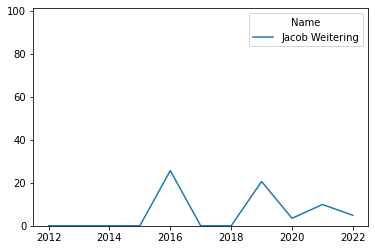

In [44]:
ax1= final.plot().set_ylim(0, 101)

In [45]:
final2 = final.mean()

In [46]:
final2

Name
Jacob Weitering    5.862345
dtype: float64

In [47]:
# for a specific player, find their best combination of weights

# generate 3 random numbers that sum to 1

def get_numbers(defenders=False):
    numbers = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    returnable = []
    if defenders:
        for a in numbers:
            for b in numbers:
                for c in numbers:
                    num1 = a
                    num2 = b
                    num3 = c
                    if (num1 + num2 + num3 > 1):
                        continue;
                    else:
                        num4 = 1-(a+b+c)
                    returnable.append([num1, num2, num3, num4])
    else:
        for i in numbers:
            for j in numbers:
                num1 = i
                num2 = j
                if (num1 + num2 > 1):
                    continue;
                else:
                    num3 = (1-i-j)
                    returnable.append([num1, num2, num3])

    return returnable


In [48]:
x_def = get_numbers(True)
x = get_numbers()

In [49]:
max_val = 0
max_rank = 0
good_combo = []
other_vals = []
other_combos = []

if pos == "defender" or pos == "ruck":
    combinations = x_def
else:
    combinations = x
for combo in combinations:
    df = specific_players(2022, pos, first_names, last_names, combo)
    current_val = df.iloc[0][2]
    rank = df.index[0]
    if current_val >= max_val:
        max_val = current_val
        max_rank = rank
        good_combo = combo
    if rank <= 3:
        other_combos.append((combo, rank))
        other_vals.append(rank)
print(pos)
print(good_combo)
print(max_val)
print(max_rank)

defender
[0, 0, 1, 0]
64.63414634146342
30


In [50]:
# find all players who have the same combinations

In [51]:
for i in other_combos:
    print(i)

In [52]:
# key defender: 0, 0, 0.9, 0.1

In [299]:
wingers = get_wingers(2022)

In [300]:
wingers.head(50)

,firstName,surname,age,team,season,gamesPlayed,General,Attack,Defence,Overall
1,Karl,Amon,27.099804,Port Adelaide,2022,20,90.750,77.8125,69.50,80.49375
2,Andrew,Brayshaw,22.877951,Fremantle,2022,20,83.750,79.3750,72.50,79.06250
3,Bailey,Smith,21.796478,Western Bulldogs,2022,14,82.000,95.0000,59.00,79.00000
4,Zach,Merrett,26.976598,Essendon,2022,17,80.250,83.4375,66.50,77.08125
5,Jayden,Short,26.667214,Richmond,2022,20,89.000,70.3125,64.50,76.04375
6,Lachie,Whitfield,28.186753,GWS Giants,2022,16,88.000,45.6250,77.75,72.21250
7,Blake,Acres,26.965646,Fremantle,2022,16,78.500,59.0625,75.00,71.61875
8,Isaac,Smith,33.733752,Geelong Cats,2022,20,85.750,86.2500,37.75,71.50000
9,Dayne,Zorko,33.621498,Brisbane Lions,2022,17,78.500,72.5000,53.50,69.20000
10,Brandon,Ellis,29.142282,Gold Coast Suns,2022,19,69.750,50.9375,82.00,67.78125


In [301]:
aa_team = []

In [302]:
def aa_defenders(year, doNotInclude=[], max_age = 999):
    players = []
    # iterate through rows until you find a player who is not in the team yet.
    for row in get_defenders(year, 0, 0.1, 0.8, 0.1, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    for row in get_defenders(year, 0, 0, 0.3, 0.7, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_defenders(year, 0.25, 0.25, 0.25, 0.25, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_defenders(year, 0, 0, 0, 1, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_defenders(year, 0, 0.1, 0.7, 0.2, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
                
    for row in get_defenders(year, 0.2, 0, 0, 0.8, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    aa_team.append(players)
    return players
        

In [303]:
def aa_centre(year, doNotInclude=[], max_age=999):
    players = []
    # iterate through rows until you find a player who is not in the team yet.
    for row in get_wingers(year, 0.7, 0.3, 0, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    for row in get_midfielders(year, 0.4, 0.3, 0.3, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    for row in get_wingers(year, 0.7, 0.3, 0, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_rucks(year, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_midfielders(year, 0.4, 0.3, 0.3, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    for row in get_midfielders(year, 0.2, 0.8, 0, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    aa_team.append(players)
    return players

In [304]:
aa_centre(2022)

['Karl Amon',
 'Clayton Oliver',
 'Bailey Smith',
 'Max Gawn',
 'Rory Laird',
 'Christian Petracca']

In [305]:
def aa_forwards(year, doNotInclude=[], max_age=999):
    players = []
    # iterate through rows until you find a player who is not in the team yet.
    for row in get_forwards(year, 0.8, 0.2, 0, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    for row in get_forwards(year, 0, 1, 0, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_forwards(year, 0.7, 0.3, 0, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_forwards(year, 0.333, 0.333, 0.333, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_forwards(year, 0.4, 0.5, 0.1, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    for row in get_forwards(year, 0.2, 0.2, 0.8, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    aa_team.append(players)
    return players

In [306]:
def aa_interchange(year, doNotInclude=[], max_age = 999):
    players = []
    # iterate through rows until you find a player who is not in the team yet.
    for row in get_defenders(year, 0.25, 0.25, 0.25, 0.25, max_age).iterrows():
        print(row)
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
    for row in get_midfielders(year, 0.33, 0.33, 0.33, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_rucks(year, 0.33, 0.33, 0.33, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
    
    for row in get_forwards(year, 0.333, 0.333, 0.333, max_age).iterrows():
        name = row[1][0] + " " + row[1][1]
        if (not(name in players) and not(name in doNotInclude)):
            players.append(name)
            break
            
            
    aa_team.append(players)
    return players

In [307]:
aa_team = []

In [320]:
def all_aus_team(year, max_age=999):
    team = []
    defenders = aa_defenders(year, max_age = max_age)
    appendList(team, defenders)
    midfielders = aa_centre(year, team, max_age = max_age)
    appendList(team, midfielders)
    forwards = aa_forwards(year, team, max_age = max_age)
    appendList(team, forwards)
    interchange = aa_interchange(year, team, max_age = max_age)
    appendList(team, interchange)
    return team
    
    

In [321]:
def appendList(this, that):
    for x in that:
        this.append(x)

In [322]:
x = all_aus_team(2022, 999)
for i in range(len(x)):
    if (i % 3 == 0):
        print("--")
    print(x[i])
    

(1, firstName              Jordan
surname                Dawson
age                   25.4598
team           Adelaide Crows
season                   2022
gamesPlayed                22
General               93.2143
Defence               95.1153
Intercepts            76.6429
Attack                97.3571
Overall               90.5824
Name: 1, dtype: object)
(2, firstName         James
surname          Sicily
age             27.7158
team           Hawthorn
season             2022
gamesPlayed          22
General         96.7857
Defence         55.5932
Intercepts      94.2143
Attack          93.5357
Overall         85.0322
Name: 2, dtype: object)
(3, firstName               Tom
surname             Stewart
age                 29.5283
team           Geelong Cats
season                 2022
gamesPlayed              17
General             95.7143
Defence              52.855
Intercepts          91.2857
Attack              95.1429
Overall             83.7495
Name: 3, dtype: object)
(4, firstName 

In [323]:
all_aus_team(2022)

(1, firstName              Jordan
surname                Dawson
age                   25.4598
team           Adelaide Crows
season                   2022
gamesPlayed                22
General               93.2143
Defence               95.1153
Intercepts            76.6429
Attack                97.3571
Overall               90.5824
Name: 1, dtype: object)
(2, firstName         James
surname          Sicily
age             27.7158
team           Hawthorn
season             2022
gamesPlayed          22
General         96.7857
Defence         55.5932
Intercepts      94.2143
Attack          93.5357
Overall         85.0322
Name: 2, dtype: object)
(3, firstName               Tom
surname             Stewart
age                 29.5283
team           Geelong Cats
season                 2022
gamesPlayed              17
General             95.7143
Defence              52.855
Intercepts          91.2857
Attack              95.1429
Overall             83.7495
Name: 3, dtype: object)
(4, firstName 

['James Sicily',
 'Tom Stewart',
 'Jordan Dawson',
 'Isaac Cumming',
 'Sam Taylor',
 'Sam Docherty',
 'Karl Amon',
 'Clayton Oliver',
 'Isaac Smith',
 'Max Gawn',
 'Rory Laird',
 'Christian Petracca',
 'Jeremy Cameron',
 'Tom Hawkins',
 'Shai Bolton',
 'Isaac Heeney',
 'Taylor Walker',
 'Dylan Moore',
 'Nick Vlastuin',
 'Marcus Bontempelli',
 'Sean Darcy',
 'Ben Ainsworth']

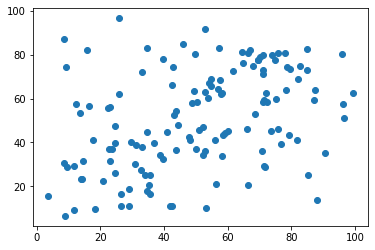

In [252]:
plt.scatter(get_midfielders(2022)["Attack"], get_midfielders(2022)["Defence"])

In [324]:
get_midfielders(2022).sort_values(by="Defence", ascending=False).head(10)

,firstName,surname,age,team,season,gamesPlayed,General,Attack,Defence,Overall
58,Sam,Berry,20.613702,Adelaide Crows,2022,18,53.085106,27.393617,96.595745,58.430851
16,Jack,Steele,26.782206,St Kilda,2022,18,82.482270,53.102837,94.326241,77.221631
25,Josh,Dunkley,25.706209,Western Bulldogs,2022,22,76.028369,57.978723,84.680851,73.209220
81,Hugh,Greenwood,30.552304,North Melbourne,2022,21,46.914894,10.106383,84.539007,47.159574
75,Willem,Drew,23.981327,Port Adelaide,2022,22,44.893617,19.326241,84.468085,49.095745
49,James,Rowbottom,22.012772,Sydney Swans,2022,21,50.992908,51.950355,84.397163,61.301418
50,Matt,Rowell,21.232469,Gold Coast Suns,2022,22,64.468085,34.219858,83.971631,61.244681
4,Marcus,Bontempelli,26.834227,Western Bulldogs,2022,21,74.468085,96.099291,83.829787,83.765957
29,Tim,Taranto,24.654853,GWS Giants,2022,16,69.113475,65.868794,83.546099,72.469858
15,Luke,Parker,29.914372,Sydney Swans,2022,22,78.936170,71.542553,81.063830,77.356383


In [329]:
get_forwards(2022, 0.6, 0.2, 0.2).head(50)

,firstName,surname,age,team,season,gamesPlayed,General,Attacking,Pressure,Overall
1,Dylan,Moore,23.140790,Hawthorn,2022,22,89.119718,56.338028,94.894366,83.718310
2,Ben,Ainsworth,24.619260,Gold Coast Suns,2022,22,88.908451,70.070423,79.753521,83.309859
3,Taylor,Walker,32.416819,Adelaide Crows,2022,18,83.943662,90.000000,70.140845,82.394366
4,Isaac,Heeney,26.387948,Sydney Swans,2022,22,82.676056,72.112676,89.647887,81.957746
5,Jeremy,Cameron,29.481783,Geelong Cats,2022,21,90.352113,92.676056,31.514085,79.049296
6,Shai,Bolton,23.795150,Richmond,2022,22,90.457746,81.478873,39.788732,78.528169
7,Toby,Greene,28.997173,GWS Giants,2022,15,87.852113,82.957746,44.894366,78.281690
8,Charlie,Curnow,25.637761,Carlton,2022,22,86.267606,89.366197,40.704225,77.774648
9,Lance,Franklin,35.650287,Sydney Swans,2022,20,77.605634,87.676056,68.309859,77.760563
10,Josh,Dunkley,25.706209,Western Bulldogs,2022,22,80.563380,50.211268,90.704225,76.521127


In [330]:
get_midfielders(2022)

,firstName,surname,age,team,season,gamesPlayed,General,Attack,Defence,Overall
1,Clayton,Oliver,25.175055,Melbourne,2022,21,98.439716,79.255319,78.014184,86.556738
2,Rory,Laird,28.737072,Adelaide Crows,2022,20,97.517730,76.241135,80.000000,85.879433
3,Patrick,Cripps,27.521441,Carlton,2022,21,88.226950,82.978723,80.425532,84.312057
4,Marcus,Bontempelli,26.834227,Western Bulldogs,2022,21,74.468085,96.099291,83.829787,83.765957
5,Touk,Miller,26.587815,Gold Coast Suns,2022,22,89.078014,84.574468,74.042553,83.216312
...,...,...,...,...,...,...,...,...,...,...
137,Xavier,O'Halloran,22.204426,GWS Giants,2022,14,4.397163,11.613475,21.702128,11.753546
138,Jeremy,Sharp,21.114739,Gold Coast Suns,2022,12,1.631206,30.851064,5.390071,11.524823
139,Callum,Ah Chee,24.958760,Brisbane Lions,2022,18,9.290780,12.765957,10.780142,10.780142
140,Flynn,Perez,21.081884,North Melbourne,2022,16,10.070922,5.496454,16.312057,10.570922


In [339]:
get_midfielders(2022).head(20).round(0)

,firstName,surname,age,team,season,gamesPlayed,General,Attack,Defence,Overall
1,Clayton,Oliver,25.0,Melbourne,2022,21,98.0,79.0,78.0,87.0
2,Rory,Laird,29.0,Adelaide Crows,2022,20,98.0,76.0,80.0,86.0
3,Patrick,Cripps,28.0,Carlton,2022,21,88.0,83.0,80.0,84.0
4,Marcus,Bontempelli,27.0,Western Bulldogs,2022,21,74.0,96.0,84.0,84.0
5,Touk,Miller,27.0,Gold Coast Suns,2022,22,89.0,85.0,74.0,83.0
6,Christian,Petracca,27.0,Melbourne,2022,22,86.0,99.0,62.0,83.0
7,Lachie,Neale,29.0,Brisbane Lions,2022,22,92.0,81.0,70.0,82.0
8,Ben,Keays,26.0,Adelaide Crows,2022,22,83.0,77.0,74.0,79.0
9,Darcy,Parish,25.0,Essendon,2022,16,96.0,76.0,59.0,79.0
10,Zach,Merrett,27.0,Essendon,2022,19,81.0,87.0,68.0,79.0
